# Disappearing Forests - Milestone 2


## Introduction
In this notebook, we would try to answer these research questions using our data analysis skills. To do so, we set up some goals to achieve:
- Identify the trend of deforestation in the world
- Find the most deforested countries/areas
- Investigate the deforestation in the most forested countries
- Find the biggest producer of wood and investigate the impact of wood mining on deforestation
- Look for the biggest importer/exporter in the world and the connection among them
- Search for correlation between agriculture industry/animal husbandry and deforestation

## Data Preprocessing
The initial preprocessing of the data was using __Shell__. The script used for preprocessing the normalized datasets from __FAOSTAT__ can be found in `data/faostat/clean_me.sh`. Here is the list of the datasets that we would work on.

- `Inputs_LandUse_E_All_Data_cleared.csv`
- `Environment_LandCover_E_All_Data_cleared.csv`
- `Environment_LandUse_E_All_Data_cleared.csv`
- `Environment_LivestockPatterns_E_All_Data_cleared.csv`
- `Forestry_E_All_Data_cleared.csv`
- `Forestry_Trade_Flows_E_All_Data_cleared.csv`
- `FAOSTAT_countries.csv`

In [2]:
# all the necessary imports
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from bokeh.layouts import widgetbox, row, column
import geopandas as gpd
import json

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [3]:
# FAOSTAT are splitted into multiple groups
# FAOSTAT_countries consists of names of the countries
# FAOSTAT_country_groups consists of bigger regions, such as (Europe, Americas, East Europe etc.)
FAOSTAT_country_data = pd.read_csv("data/faostat/FAOSTAT_countries.csv", engine='python')
FAOSTAT_country_groups = FAOSTAT_country_data["Country Group"].unique()
FAOSTAT_countries = FAOSTAT_country_data["Country"].unique()
CONTINENTS = ['Africa', 'Asia', 'Oceania', 'Europe', 'Northern America', 'South America', 'Antarctic Region']

## 1. The Deforestation Trend
In this section, we try to explore in the data set `Inputs_LandUse_E_All_Data_cleared.csv` to find out related information about forestation and deforestation in each country. Ultimately, we would like to figure out the trend of deforestation over the time span in each country.

### Forests in each country
In this part, we would dive into the dataset `Inputs_LandUse_E_All_Data_cleared.csv` to see forest situation in the nations around the globe, intending to compare the distribution among them.

In [4]:
# select forestation related features from Inputs_LandUse 
LAND_USE_FOREST_ITEMS = ['Forestry']

land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

# change Area USSR to Russian Federation
land_use.Area = np.where(land_use['Area'] == 'USSR', 'Russian Federation', land_use.Area)

In [5]:
# foreseted areas (ha) for every contry per year
forested_area_yearly = land_use[land_use.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly_unstack = forested_area_yearly.unstack("Year")

Here we present top 5 countries' forestation status (those having top 5 most important forestation matching to the record in [**Wiki**](https://en.wikipedia.org/wiki/List_of_countries_by_forest_area)). Specifically, we would take a look at their forest areas from 1990 to 2017.

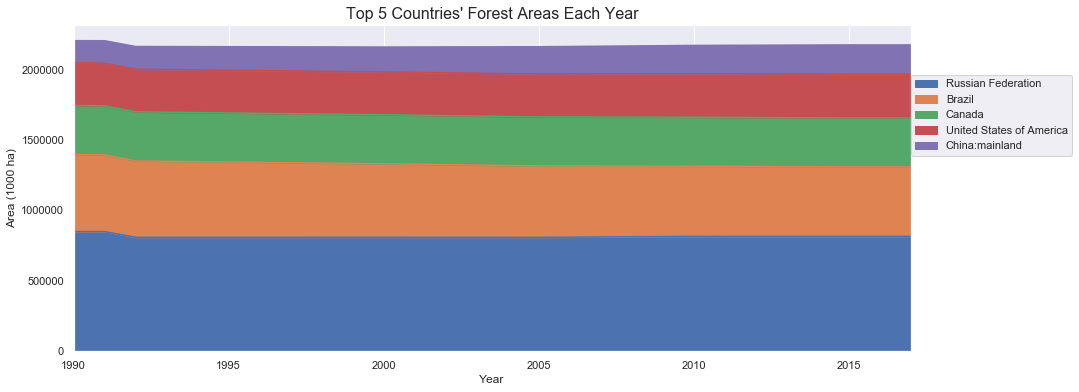

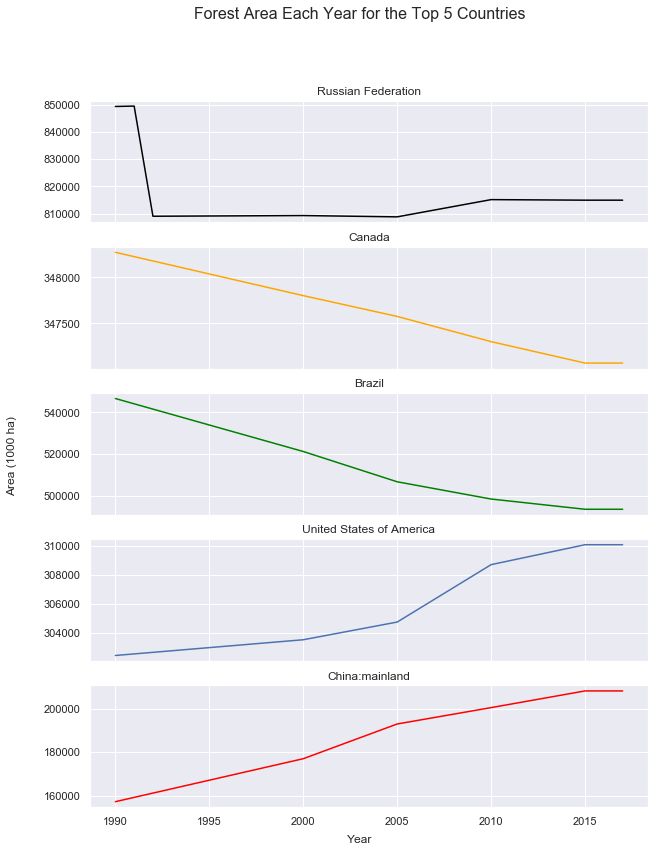

In [6]:
# plot the forest area of top 5 countries containing most important forestation 
forested_area_yearly_unstack.loc[['Russian Federation', 'Brazil', 'Canada', 'United States of America', 'China:mainland'], :]\
                            .T.plot.area(figsize = (15, 6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title("Top 5 Countries' Forest Areas Each Year", fontsize = 16)
plt.show()

# look in more detailed for those top 5
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly.loc['Russian Federation'], color = 'black')
axes[1].plot(forested_area_yearly.loc['Canada'], color = 'orange')
axes[2].plot(forested_area_yearly.loc['Brazil'], color = 'green')
axes[3].plot(forested_area_yearly.loc['United States of America'])
axes[4].plot(forested_area_yearly.loc['China:mainland'], color = 'red')
axes[0].set_title('Russian Federation')
axes[1].set_title('Canada')
axes[2].set_title('Brazil')
axes[3].set_title('United States of America')
axes[4].set_title('China:mainland')
fig.suptitle("Forest Area Each Year for the Top 5 Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in the plot, both Brazil and Canada have decreasing forest areas in every coming year.
- On the contrary, USA and China respectively have the postive trend of increasing forest areas.
- As for Russia, we can see that there is a sudden drop from 1990, which may result from dissolution of Soviet Union and reduce the forest areas in Russia. Reference is [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union)

In [7]:
# load county codes and adjust missing values
coutry_codes = FAOSTAT_country_data[["Country", "ISO3 Code"]].drop_duplicates()
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "Country"] = "China"
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "ISO3 Code"] = "SDN"

# load 'Environment_LandUse_E_All_Data_cleared.csv' data set and filter columns
env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')
env_land_use = env_land_use_all[env_land_use_all.Item.isin(['Forest land']) & env_land_use_all.Element.str.match("Share in Land area")][["Area", "Year", "Value"]]

# join the codes to the countires
env_land_use = env_land_use.merge(coutry_codes, how='left', left_on='Area', right_on='Country').drop('Country', axis=1)

# load shapes of the countries and load it to Geopandas
shapefile = 'data/map/ne_110m_admin_0_countries.shp'

# rename columns and drop Antarctica
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

# select the most recent year in the data set
env_land_use_2016 = env_land_use[env_land_use['Year'] == 2016]

# merge dataframes gdf and env_land_use_2016
merged = gdf.merge(env_land_use_2016, left_on = 'country_code', right_on = 'ISO3 Code', how = 'left')

# read data to json and convert to String like object
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

# input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)
# define a sequential multi-hue color palette.
palette = brewer['YlGn'][8]
# reverse color order
palette = palette[::-1]
# instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 70)
# define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '40%', '45': '45%' , '50': '50%', '55': '55%', '60': '>60%'}

# add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('% Forrested area', '@Value')])

# create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
# create figure object
p = figure(title = 'Share of forrest, 2016', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Value', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
# specify figure layout
p.add_layout(color_bar, 'below')
# display figure inline in Jupyter Notebook
output_notebook()
# display figure
show(p)


Loading BokehJS ...

Next, from the broader view, we would like to check the forest areas in each continent.

In [8]:
# forest areas in continents over years
continents_forests_area = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &   
                                       land_use_all.Element.str.match('Area') & 
                                       land_use.Area.isin(CONTINENTS)].groupby(["Area", "Year"]).Value.sum()

continents_forests_area_unstack = continents_forests_area.unstack("Year")

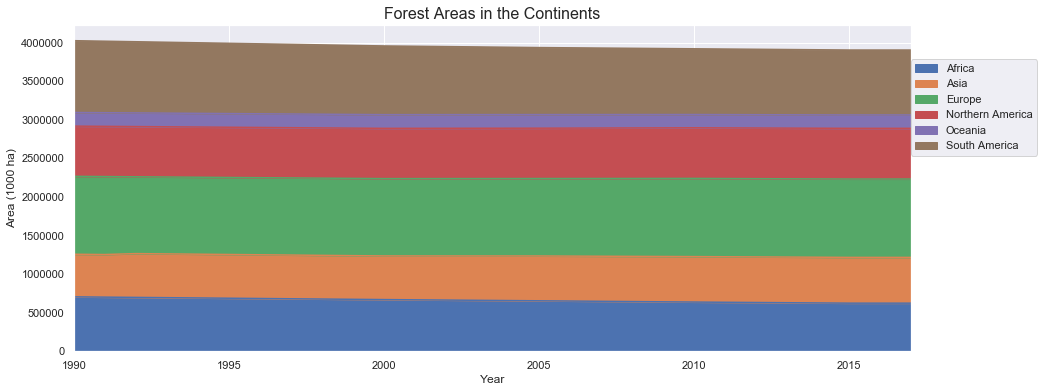

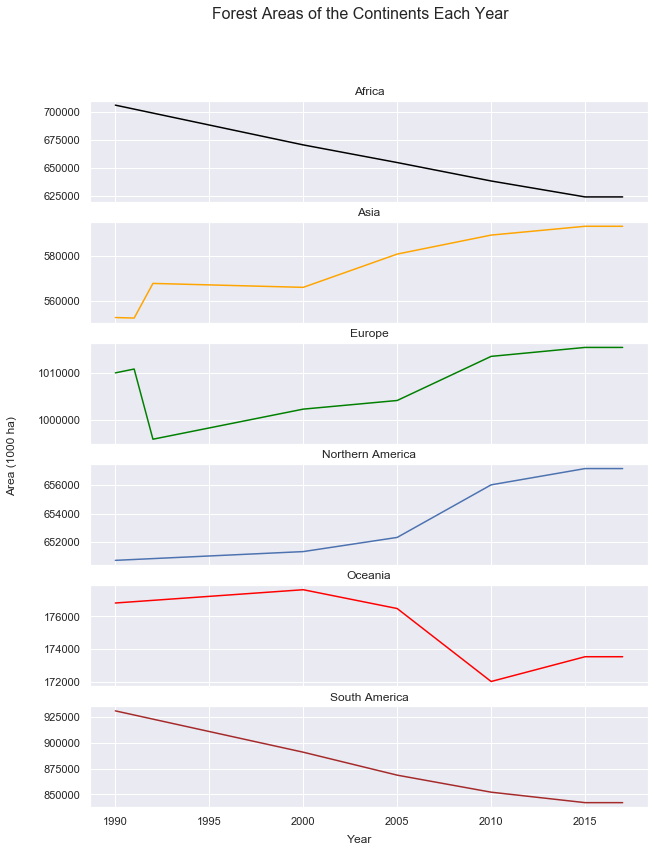

In [9]:
# plot forested areas in continents over the years
continetns_forests_plot = continents_forests_area_unstack.T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title('Forest Areas in the Continents', fontsize = 16)
plt.show()

# look deeper for each continent
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 13))
axes[0].plot(continents_forests_area.loc['Africa'], color = 'black')
axes[1].plot(continents_forests_area.loc['Asia'], color = 'orange')
axes[2].plot(continents_forests_area.loc['Europe'], color = 'green')
axes[3].plot(continents_forests_area.loc['Northern America'])
axes[4].plot(continents_forests_area.loc['Oceania'], color = 'red')
axes[5].plot(continents_forests_area.loc['South America'], color = 'brown')
axes[0].set_title('Africa')
axes[1].set_title('Asia')
axes[2].set_title('Europe')
axes[3].set_title('Northern America')
axes[4].set_title('Oceania')
axes[5].set_title('South America')
fig.suptitle("Forest Areas of the Continents Each Year", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- From the plot, both Africa and South America steadily reduce their forest area over the years.
- Similarly but slightly bizarrely, we can see that the trend in Oceania went upward at first (until 2000) but then dropped sharply in 2005. We doubt that there may be some interesting factors causing this phenomenon.
- In contrast, the rest such as Asia, Europe, and North America continually enlarges their forest areas.

As in many real-world datasets, we encountered the missing values here. Thus, we decided to use median to impute them for each continent.

In [10]:
# replace missing values by median along each column
forested_area_yearly_unstack = forested_area_yearly_unstack.interpolate(axis = 1)

### Deforestation in each country
In this part, we focus on examining the reduction of forests in every country from 1990 to 2017. Mainly we would like to compare the reduction between the first year and the last year.

In [11]:
# helpful functions to extract first and last non-null values
def first(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]
    
def last(x):
    if x.last_valid_index() is None:
        return None
    else:
        return x[x.last_valid_index()]

In [12]:
# top 5 countries which have deforestated most of forested areas over these years
forested_areas_diff = forested_area_yearly_unstack.apply(first, axis=1) - forested_area_yearly_unstack.apply(last, axis=1)
forested_areas_diff = forested_areas_diff.sort_values(ascending=False)
forested_areas_diff.head()

Area
Brazil                53167.0
Russian Federation    34493.9
Indonesia             27535.0
Nigeria               10241.0
Myanmar               10177.0
dtype: float64

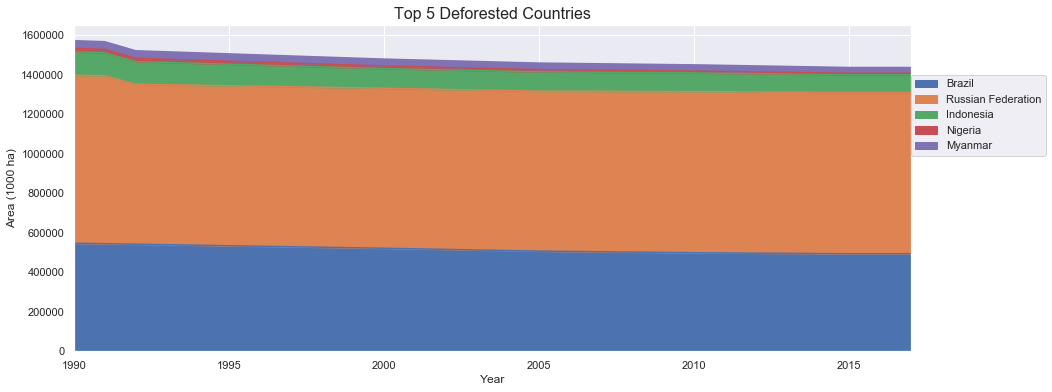

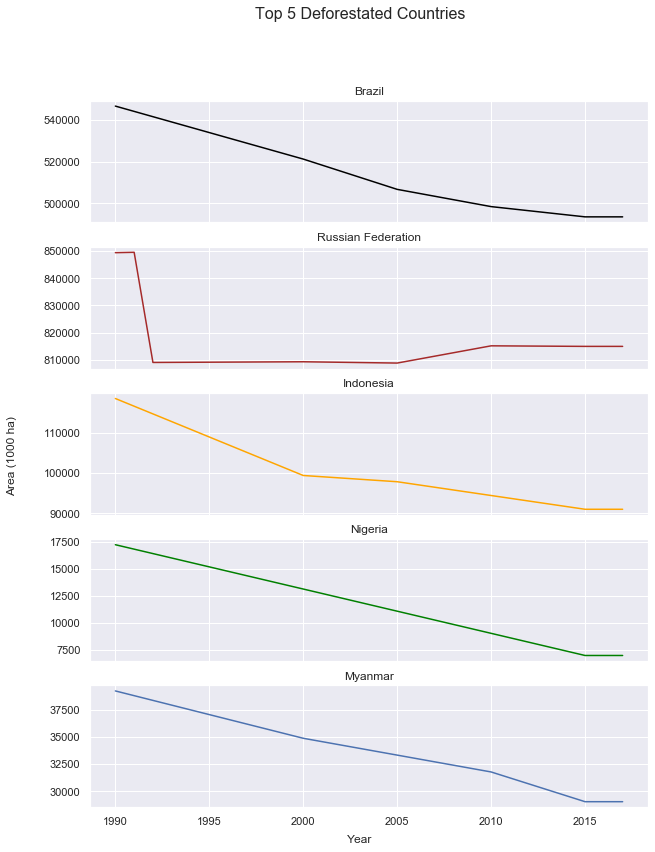

In [13]:
# top 5 countries which have deforestated most of forested areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Russian Federation'], color = 'brown')
axes[2].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[3].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[4].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[0].set_title('Brazil')
axes[1].set_title('Russian Federation')
axes[2].set_title('Indonesia')
axes[3].set_title('Nigeria')
axes[4].set_title('Myanmar')
fig.suptitle("Top 5 Deforestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- We notice that the rapid reduction in Russia is mainly from 1991 to 1992.
- We speculate that the reason why Russia decreased much forests areas at that time is due to the collapse of Soviet Union, shrinking Russia's territory.
- In this case, we remove Russia to exclude the political issue.
- Look for more details, check [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union)

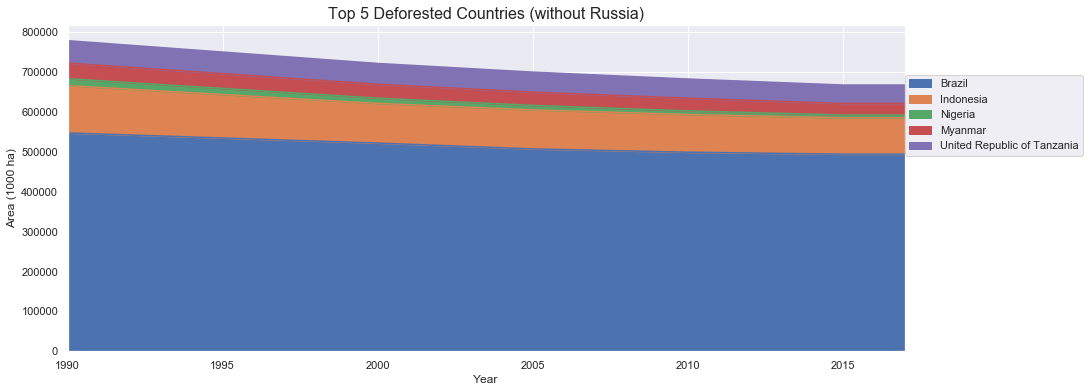

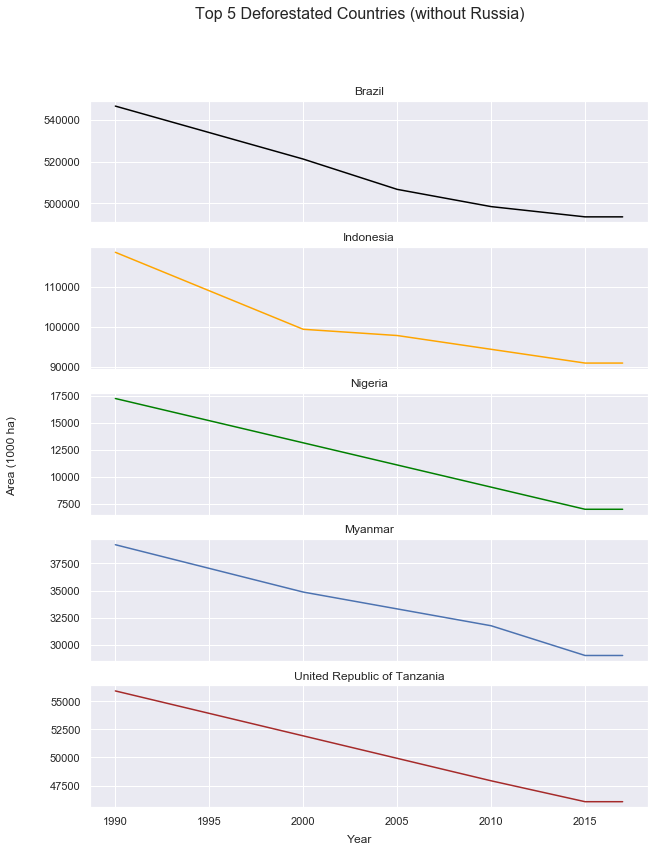

In [14]:
# top 5 countries which have deforestated most of forested areas over the years (without Russia)
forested_area_yearly_unstack.loc[forested_areas_diff[[0, 2, 3, 4, 5]].index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries (without Russia)', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[4].plot(forested_area_yearly_unstack.loc['United Republic of Tanzania'], color = 'brown')
axes[0].set_title('Brazil')
axes[1].set_title('Indonesia')
axes[2].set_title('Nigeria')
axes[3].set_title('Myanmar')
axes[4].set_title('United Republic of Tanzania')
fig.suptitle("Top 5 Deforestated Countries (without Russia)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in both plots, these top 5 deforested countries have been all steadily decreasing their forest areas (with almost the same trend).
- At first, Indonesia had more rapid deforestation trend; however, after 2000, the trend slowed down.

In [15]:
# top 5 countries with biggest expansion of forests (Note: Russian Federation seems as an outlier)
forested_areas_diff.tail()

Area
Spain                       -4608.38
Viet Nam                    -5410.00
India                       -6743.00
United States of America    -7645.00
China:mainland             -51180.70
dtype: float64

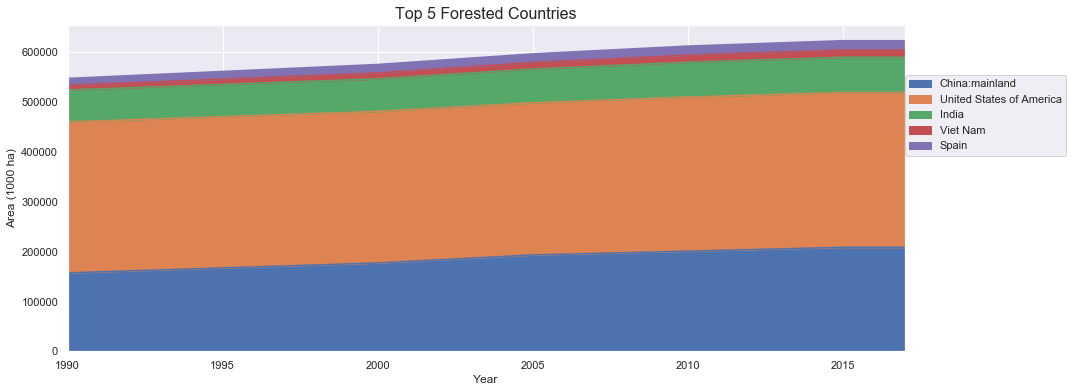

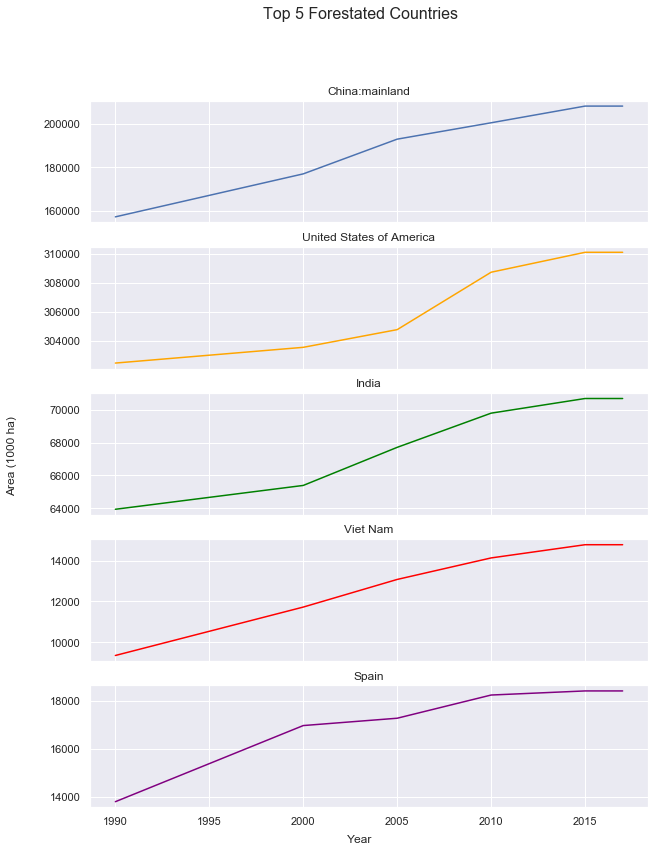

In [16]:
# top 5 countries which have forestated forest areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.sort_values(ascending= True).head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Forested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['China:mainland'])
axes[1].plot(forested_area_yearly_unstack.loc['United States of America'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['India'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Viet Nam'], color = 'red')
axes[4].plot(forested_area_yearly_unstack.loc['Spain'], color = 'purple')
axes[0].set_title('China:mainland')
axes[1].set_title('United States of America')
axes[2].set_title('India')
axes[3].set_title('Viet Nam')
axes[4].set_title('Spain')
fig.suptitle("Top 5 Forestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- Suprisingly, most of top 5 countries with fast-growing forest areas are developing countries such as China, India, and Vietnam.
- Let's look for more information why this occurs!

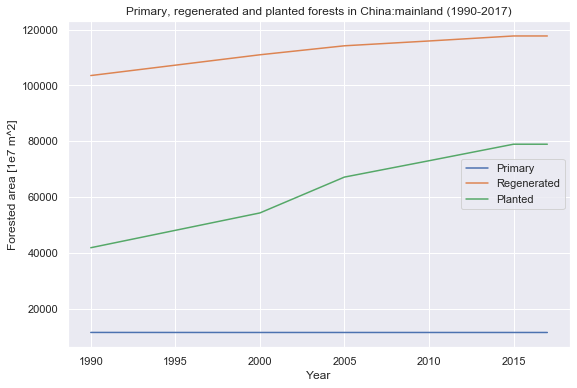

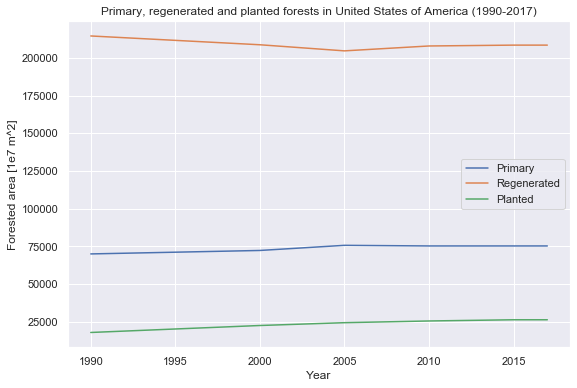

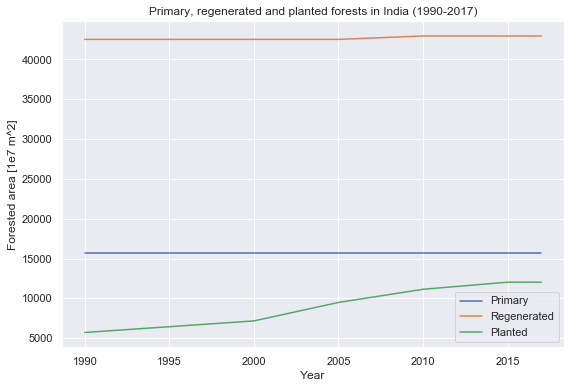

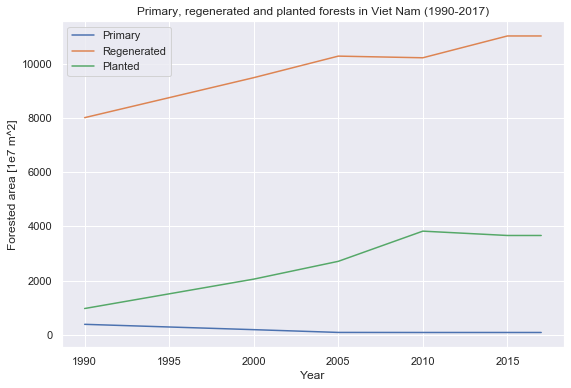

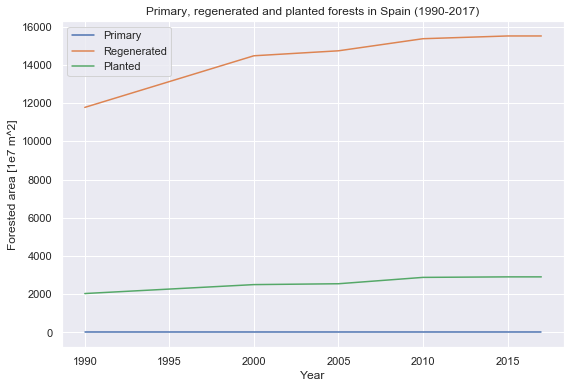

In [18]:
# plot the three kinds of forest (primary, regenerated and planted) for the selected country
LAND_USE_PARTIAL_FOREST_ITEMS = ['Primary Forest', 'Other naturally regenerated forest', 'Planted Forest']
land_use_detail = land_use_all[land_use_all.Item.isin(LAND_USE_PARTIAL_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

# plot three types of trees for China
COUNTRY = 'China:mainland'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for USA
COUNTRY = 'United States of America'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for India
COUNTRY = 'India'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for Vietnam
COUNTRY = 'Viet Nam'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

# plot three types of trees for Spain
COUNTRY = 'Spain'
country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                             (land_use_all['Area'] == COUNTRY)]

plt.figure(figsize=(9, 6))
for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
    plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
             country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
plt.title('Primary, regenerated and planted forests in ' + COUNTRY + ' (1990-2017)')
plt.legend(['Primary', 'Regenerated', 'Planted'])
plt.gca().set_xlabel('Year')
plt.gca().set_ylabel('Forested area [1e7 m^2]')
plt.show()

> #### ***Explanation***
- From our investigation on these types of trees for each country, the reason why China could increase its forest area is because of planted trees by its people and large number of naturally regenerated trees.
- As for USA, it mostly depends on regenerated trees for expansion of its forestation.
- For India, similar to China, India has expanded their forestation by planted trees since 2000.
- For Vietnam, at first, its trend of growing forest area was based on regenerated trees and planted ones; however, after 2010, the trend has slowed down, remaining the same.
- Lastly, for Spain, it primarily relies on the regenerated trees for forestation expansion.

In this section, we try to research on the dataset `Environment_LandUse_E_All_Data_cleared.csv` to find out ***percentage*** of forestation and deforestation in each country. Still, we would like to figure out the trend of deforestation in percentage over the time span in each country.

In [25]:
# load ENV LansUse and select share of the forests in the each Area per yesr 
ENV_LAND_USE_FOREST = ['Forest land', 'Primary Forest', 'Planted Forest', 
                       'Other naturally regenerated forest']

env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')

env_land_use = env_land_use_all[env_land_use_all.Item.isin(ENV_LAND_USE_FOREST) & env_land_use_all.Element.str.match("Share in Land area")]

env_land_use_yearly = env_land_use.groupby(["Area", "Year"]).Value.sum()
env_land_use_yearly = env_land_use_yearly.unstack("Year").fillna(method="backfill", axis=0)

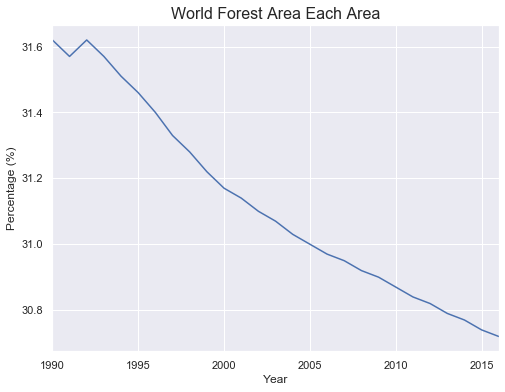

In [26]:
# plot the percentage of world forest areas 
env_land_use_yearly.loc['World'].plot(figsize = (8, 6))
plt.title('World Forest Area Each Year', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.show()

> #### ***Explanation***
- Sadly,  the world forest percentage is continuously decreasing, and it has dropped almost 1 percent since 1990s.
- More specifically, total deforestation area is equalivent to almost 30 times the territory of Switzerland.

In [27]:
# compute the percentage of deforestation for each country
env_land_use_diff = env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, 0]\
                                        - env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, -1]

env_land_use_diff = env_land_use_diff.sort_values(ascending=False)

In [28]:
# top 5 countries which have deforestated by % of deforestated areas
env_land_use_diff.head()

Area
Pacific Islands Trust Territory    80.36
Serbia                             57.29
Azerbaijan                         37.35
Honduras                           32.74
USSR                               29.07
dtype: float64

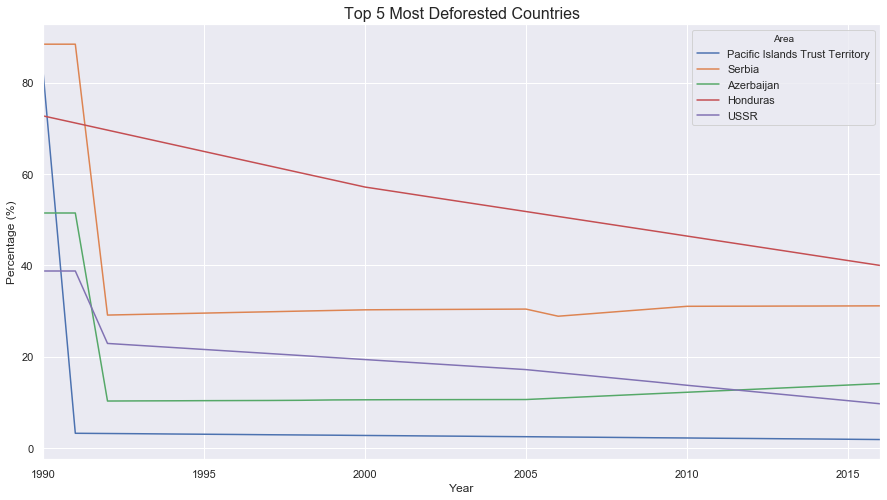

In [30]:
# plot the top 5 countries with most deforestation
env_land_use_yearly.loc[env_land_use_diff.head().index].T.plot(figsize=(15,8))
plt.title('Top 5 Most Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.show()

> #### ***Explanation***
- Interestingly, top 5 countries except Honduras had decreased their forest percentage during early 1900s, and after that, these percentages remain stable to 2017.

In [31]:
# show top 5 least deforested countries
env_land_use_diff.tail()

Area
Belgium-Luxembourg                 -36.43
Russian Federation                 -36.87
Micronesia (Federated States of)   -42.36
Netherlands Antilles (former)      -44.42
Sudan (former)                     -85.33
dtype: float64

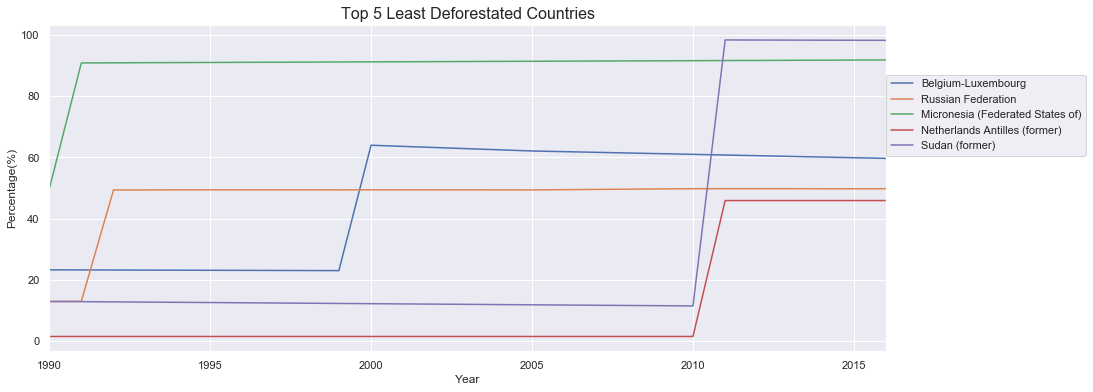

In [33]:
# plot the line graph to show the trend
env_land_use_yearly.loc[env_land_use_diff.tail().index].T.plot(figsize=(15,6))
plt.title('Top 5 Least Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage(%)')
plt.legend(loc = (1, 0.6))
plt.show()

> #### ***Explanation***
- We could observe that instead of growing steadily, the trends of all top 5 deforestated countries have a sudden jump in different times, making their forest areas change rapidly within few years. 

### Environment_LandCover_E_All_Data_cleared.csv

In [29]:
# load ENV landCover and select tree covered areas (per country per year) and split them by origin
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

env_land_cover_MODIS = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") & env_land_cover_all.Element.str.match("Area from MODIS")]\
                                         .groupby(["Area", "Year"])\
                                         .Value.sum()\
                                         .unstack("Year")\
                                         .fillna(method="backfill")

env_land_cover_CCI_LC = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") & env_land_cover_all.Element.str.match("Area from CCI_LC")]\
                                          .groupby(["Area", "Year"])\
                                          .Value.sum()\
                                          .unstack("Year")\
                                          .fillna(method="backfill")

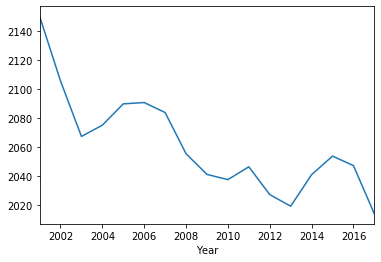

In [30]:
# plot forest in Switzerland per year base on the MODIS data
env_land_cover_MODIS.loc["Switzerland"].plot()
plt.show()

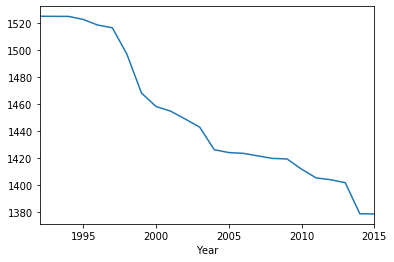

In [31]:
# plot forest are in Switzerland per year base on the CCI_LC data
env_land_cover_CCI_LC.loc["Switzerland"].plot()
plt.show()

#### Note to the CCI_LC & MODIS
**MODIS** data are only from the year 2001, they seem to differ from the **CCI_LC** data.


## 2. The Wood Trade
Now, based on `data/faostat/Forestry_E_All_Data_cleared.csv` and `data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv`, we start to look for the biggest producers and consumers of the wood in the world.

In [3]:
# load Forestry data
forest_all = pd.read_csv("data/faostat/Forestry_E_All_Data_cleared.csv", engine='python')
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')

In [4]:
PRIMARY_FORREST_PRODUCTS = ['Roundwood', 'Sawnwood']

# the top 10 countries by deforested land area since 2010 (incl.)
DEC_FOREST = ['Brazil', 'Indonesia', 'Myanmar', 'Nigeria',
                  'United Republic of Tanzania', 'Paraguay', 'Zimbabwe',
                  'Democratic Republic of the Congo', 'Argentina',
                  'Bolivia (Plurinational State of)']

# the top 10 countries by forested land area since 2010 (incl.)
INC_FOREST = ['France', 'Viet Nam', 'India', "Lao People's Democratic Republic",
                'Gabon', 'Philippines', 'United States of America', 'Chile',
                'Australia', 'China:mainland']

In [17]:
# the wood production of countries in m3
wood_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) &
                                forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS) &
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

# aggreaged production of wood since 2010
wp_agg = forest_all[(forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS)) & (forest_all.Year >= 2010) & (forest_all.Unit.str.match("m3")) & (forest_all.Element.str.match('Production')) & (forest_all.Area.isin(FAOSTAT_countries))]

In [11]:
# production of the wood in the world
world_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.str.startswith("World") &
                                forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS) &
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

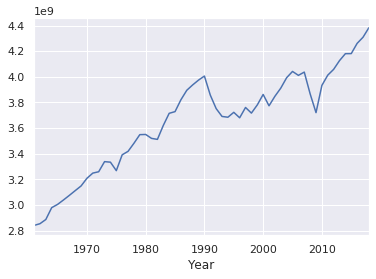

In [13]:
# the wood production in the world
world_production_m3.loc["World"].plot()
plt.show()

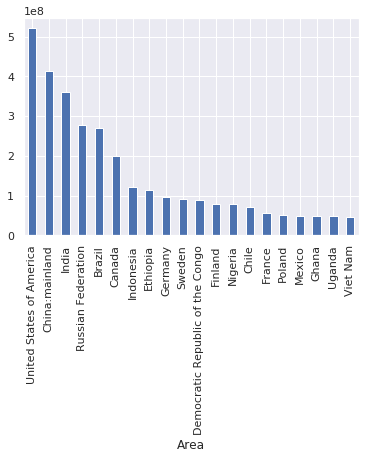

In [14]:
# the biggest producer of wood in 2018
wood_production_m3.loc[:, 2018].sort_values(ascending=False).head(20).plot.bar()

In [18]:
# rank countires by their wood production since 2010
wp_agg = wp_agg.groupby("Area").Value.sum()
wp_agg = wp_agg.to_frame()
wp_agg["rank"] = wp_agg.Value.rank(ascending=False)
wp_agg = wp_agg.reset_index()

In [20]:
# wood production of the top 10 countries by decreased forest area
wp_agg[wp_agg.Area.isin(DEC_FOREST)].sort_values(by='rank')

,Area,Value,rank
23,Brazil,2.431647e+09,4.0
88,Indonesia,1.117080e+09,7.0
51,Democratic Republic of the Congo,7.725738e+08,10.0
136,Nigeria,6.885227e+08,12.0
127,Myanmar,4.068526e+08,20.0
195,United Republic of Tanzania,2.388498e+08,32.0
5,Argentina,1.731315e+08,40.0
145,Paraguay,1.044092e+08,59.0
205,Zimbabwe,8.815796e+07,63.0
20,Bolivia (Plurinational State of),3.449735e+07,103.0


In [21]:
# wood production of the top 10 countries by increased forest area
wp_agg[wp_agg.Area.isin(INC_FOREST)].sort_values(by='rank')

,Area,Value,rank
196,United States of America,4.285439e+09,1.0
39,China:mainland,3.616067e+09,2.0
87,India,3.269145e+09,3.0
35,Chile,5.871277e+08,14.0
68,France,5.400872e+08,15.0
201,Viet Nam,4.049915e+08,21.0
8,Australia,3.316286e+08,22.0
147,Philippines,1.474655e+08,44.0
102,Lao People's Democratic Republic,8.070786e+07,67.0
71,Gabon,3.374577e+07,105.0


In [57]:
# load county codes and adjust missing values
coutry_codes = FAOSTAT_country_data[["Country", "ISO3 Code"]].drop_duplicates()
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "ISO3 Code"] = "CHN"

# join the codes to the countires
wp_agg['Val_bil'] = wp_agg.Value / 1000000000
wp_map = wp_agg.merge(coutry_codes, how='left', left_on='Area', right_on='Country').drop('Country', axis=1)

# load shapes of the countries and load it to Geopandas
shapefile = 'data/map/ne_110m_admin_0_countries.shp'

# rename columns and drop Antarctica
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

# select the most recent year in the data set
#wp_map_2016 = wp_map[wp_map['Year'] == 2016]

# merge dataframes gdf and env_land_use_2016
merged = gdf.merge(wp_map, left_on = 'country_code', right_on = 'ISO3 Code', how = 'left')

# read data to json and convert to String like object
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

# input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)
# define a sequential multi-hue color palette.
palette = brewer['YlOrBr'][8]
# reverse color order
palette = palette[::-1]
# instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4285438664.0)
# define custom tick labels for color bar.

# add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('Production (10^9 m3)', '@Val_bil')])

# create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')
# create figure object
p = figure(title = 'Production of wood, since 2010', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Value', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
# specify figure layout
p.add_layout(color_bar, 'below')
# display figure inline in Jupyter Notebook
output_notebook()
# display figure
show(p)

Loading BokehJS ...

In [58]:
trade_all = forest_trade[forest_trade.Element.str.match("Export Value")][["Reporter Countries", "Partner Countries", "Item", "Year", "Unit", "Value"]].rename(columns={"Reporter Countries": "Exporting Country", "Partner Countries": "Importing Country"})

trade_all= trade_all[~trade_all["Importing Country"].str.match("Total FAO")]

In [61]:
trade_all

,Exporting Country,Importing Country,Item,Year,Unit,Value
12,Afghanistan,Austria,Forest products (export/import),2000,1000 US$,3.0
13,Afghanistan,Austria,Forest products (export/import),2001,1000 US$,3.0
14,Afghanistan,Austria,Forest products (export/import),2004,1000 US$,5.0
15,Afghanistan,Austria,Forest products (export/import),2007,1000 US$,135.0
27,Afghanistan,Austria,Industrial roundwood:non-coniferous non-tropic...,2000,1000 US$,3.0
...,...,...,...,...,...,...
2688644,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2013,1000 US$,871.0
2688645,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2014,1000 US$,774.0
2688646,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2015,1000 US$,592.0
2688647,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2016,1000 US$,868.0


In [62]:
trade_all.Item.unique()

array(['Forest products (export/import)',
       'Industrial roundwood:non-coniferous non-tropical (export/import)',
       'Sawnwood:coniferous', 'Veneer sheets', 'Plywood',
       'Paper and paperboard:excluding newsprint',
       'Sawnwood:non-coniferous all',
       'Industrial roundwood:coniferous (export/import)',
       'Industrial roundwood:non-coniferous tropical (export/import)',
       'Fibreboard', 'Newsprint', 'Wood chips and particles', 'Wood pulp'],
      dtype=object)

In [65]:
trade_all

,Exporting Country,Importing Country,Item,Year,Unit,Value
12,Afghanistan,Austria,Forest products (export/import),2000,1000 US$,3.0
13,Afghanistan,Austria,Forest products (export/import),2001,1000 US$,3.0
14,Afghanistan,Austria,Forest products (export/import),2004,1000 US$,5.0
15,Afghanistan,Austria,Forest products (export/import),2007,1000 US$,135.0
27,Afghanistan,Austria,Industrial roundwood:non-coniferous non-tropic...,2000,1000 US$,3.0
...,...,...,...,...,...,...
2688644,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2013,1000 US$,871.0
2688645,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2014,1000 US$,774.0
2688646,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2015,1000 US$,592.0
2688647,Zimbabwe,Zambia,Paper and paperboard:excluding newsprint,2016,1000 US$,868.0


## 2. Is agricultural industry influencing deforestation? 
One of the most negative influences on the deforestation might have an agricultural industry. We've decided to investigate this possible connection.

In [ ]:
#TODO

## 3. Is breeding farm animals influencing deforestation? 
Breeding animals might be space consumig, we've searched for the origin of the land used for this purpose.


In [ ]:
#TODO